# Delta Hedging

## Motivation of Dalta Hedging:
Delta hedging is an options trading strategy that aims to reduce, or hedge, the directional risk associated with price movements in the underlying asset.  
The approach uses options to offset the risk to either a single other option holding or an entire portfolio of holdings. The investor tries to reach a delta-neutral state and not have a directional bias on the hedge.  

## Framework
A stock follow a GBM with parameters: r = 0.05, vol = 0.02. Initial stock price is 100€.  
A speculator want to purchase a call with strike price 110€ and maturity 0.5.  
**What is the trader's strategie that sells the call?**

## Delta Hedging strategie:

The strategie is as follow:

- Sells the Call  
- Each day, compute the delta of the stock and ensures to hold delta units of stock     
- Put any remaining cash or debt into risk free account  
- At maturity, delivers the stock to the customer if required and sells any remaining stock 

##Cash Flow

**At time 0:**  
Customers pays the call price $P$ and the trader purchases $\Delta_0 $ stocks.  
Trader's bank balance is then
$$
b_0 = P - \Delta_0 S_0
$$

**At time $t_n$:**  
Money bank earns interest, trader purchases $\Delta_n - \Delta_{n-1}$ stocks.  
Bank balance is then:
$$
b_n = e^{r \delta t}b_{n-1} - (\Delta_n - \Delta_{n-1}) S_n
$$

**At final time T:**  
Money bank earns interest, trader sells $\Delta_{n-1}$ stocks. The traders fulfils the call option contract.  
Bank balance is then  
$$
b_n = e^{r \delta t}b_{n-1} + \Delta_{n-1} S_n + \text{max}(S_n - K, 0)
$$

In [2]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

In [4]:
# input BS
asset_price = 100
asset_volatility = 0.2
time_to_expiration = 1.0
risk_free_rate = 0.05
strike_price = 110

NbSteps = 365
NbPaths = 1000

In [5]:
class BlackScHolesClass:
    def __init__(self, asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        
        self.NbSteps = 500
        self.NbPaths = 1000
        
        self.BSpaths = self.generateBSpaths()
        self.BSpath = self.generateOneBSPath()
        
        self.price = self.call_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.call_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.gamma = self.call_gamma(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.vega = self.call_vega(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)

        self.call_quantity = 1
        self.Initial_delta = self.delta
        self.Initial_call_price = self.price
        
    def generateBSpaths(self):
        self.dt = self.time_to_expiration / self.NbSteps
        log_ST = np.log(self.asset_price) +  np.cumsum(((self.risk_free_rate - self.asset_volatility ** 2 / 2.0) * self.dt +\
                              self.asset_volatility * np.sqrt(self.dt) * \
                              np.random.normal(size=(self.NbSteps, self.NbPaths))),axis=0)
        return np.exp(log_ST)
    
    def generateOneBSPath(self):
        self.dt = self.time_to_expiration / self.NbSteps
        log_ST = np.log(self.asset_price) +  np.cumsum(((self.risk_free_rate - self.asset_volatility ** 2 / 2.0) * self.dt +\
                              self.asset_volatility * np.sqrt(self.dt) * \
                              np.random.normal(size = self.NbSteps)),axis=0)
        return np.exp(log_ST)
    
    def plot_BSPaths(self):
        plt.plot(self.BSpaths)
        plt.xlabel("Time Increments")
        plt.ylabel("Stock Price")
        plt.title("Geometric Brownian Motion")
        
    def call_payoff(self, asset_price_t, strike_price):
        return np.maximum(asset_price_t - strike_price, 0.0)

    def call_price(
            self, asset_price, asset_volatility, strike_price,
            time_to_expiration, risk_free_rate
    ):
        b = math.exp(-risk_free_rate * time_to_expiration)
        x1 = math.log(asset_price / (b * strike_price)) + .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x1 = x1 / (asset_volatility * (time_to_expiration ** .5))
        z1 = norm.cdf(x1)
        z1 = z1 * asset_price
        x2 = math.log(asset_price / (b * strike_price)) - .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x2 = x2 / (asset_volatility * (time_to_expiration ** .5))
        z2 = norm.cdf(x2)
        z2 = b * strike_price * z2
        return z1 - z2

    def call_delta(
            self, asset_price, asset_volatility, strike_price,
            time_to_expiration, risk_free_rate ):
        b = math.exp(-risk_free_rate * time_to_expiration)
        x1 = math.log(asset_price / (b * strike_price)) + .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x1 = x1 / (asset_volatility * (time_to_expiration ** .5))
        z1 = norm.cdf(x1)
        return z1

    def call_gamma(
            self, asset_price, asset_volatility, strike_price,
            time_to_expiration, risk_free_rate
    ):
        b = math.exp(-risk_free_rate * time_to_expiration)
        x1 = math.log(asset_price / (b * strike_price)) + .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x1 = x1 / (asset_volatility * (time_to_expiration ** .5))
        z1 = norm.cdf(x1)
        z2 = z1 / (asset_price * asset_volatility * math.sqrt(time_to_expiration))
        return z2

    def call_vega(
            self, asset_price, asset_volatility, strike_price,
            time_to_expiration, risk_free_rate
    ):
        b = math.exp(-risk_free_rate * time_to_expiration)
        x1 = math.log(asset_price / (b * strike_price)) + .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x1 = x1 / (asset_volatility * (time_to_expiration ** .5))
        z1 = norm.cdf(x1)
        z2 = asset_price * z1 * math.sqrt(time_to_expiration)
        return z2 / 100
    
    def GetDeltaHedging(self):
        dt = self.time_to_expiration / self.NbSteps
        self.df = np.exp(self.risk_free_rate * dt)
        times_horizon = np.linspace(0.0, self.time_to_expiration, num=self.NbSteps+1)

        stock_quantity = self.Initial_delta
        Initial_cost = stock_quantity * self.asset_price
        charge_to_customer = self.call_quantity * self.Initial_call_price
        BankBalance = charge_to_customer - Initial_cost
        
        for t in range(self.NbSteps - 1):
            S_t = self.BSpath[t]
            TimeToMaturity = self.time_to_expiration - times_horizon[t]
            delta = self.call_delta(S_t, self.asset_volatility, self.strike_price, TimeToMaturity, self.risk_free_rate)
            NewStockQuantity = delta
            AmountToBuy = NewStockQuantity - stock_quantity
            cost = AmountToBuy * S_t
            BankBalance =  self.df * BankBalance - cost
            stock_quantity = NewStockQuantity
            
        S_T = self.BSpath[-1]
        Stock_value = stock_quantity * S_T
        liability = self.call_payoff(S_T, self.strike_price)
        BankBalance = self.df * BankBalance + Stock_value - liability
        return BankBalance
    
    def MultipleDataHedging(self, simulation_test = 50, Plot=True):
        dt = self.time_to_expiration / self.NbSteps
        self.df = np.exp(self.risk_free_rate * dt)
        times_horizon = np.linspace(0.0, self.time_to_expiration, num=self.NbSteps+1)
        BankBalance_all = np.empty(0)
        for i in range(simulation_test):
            BSpath_i = self.BSpaths[:, i]
            stock_quantity = self.Initial_delta
            Initial_cost = stock_quantity * self.asset_price
            charge_to_customer = self.call_quantity * self.Initial_call_price
            BankBalance = charge_to_customer - Initial_cost
            for t in range(self.NbSteps - 1):
                S_t = BSpath_i[t]
                TimeToMaturity = self.time_to_expiration - times_horizon[t]
                delta = self.call_delta(S_t, self.asset_volatility, self.strike_price, TimeToMaturity, self.risk_free_rate)
                NewStockQuantity = delta
                AmountToBuy = NewStockQuantity - stock_quantity
                cost = AmountToBuy * S_t
                BankBalance =  self.df * BankBalance - cost
                stock_quantity = NewStockQuantity

            S_T = BSpath_i[-1]
            Stock_value = stock_quantity * S_T
            liability = self.call_payoff(S_T, self.strike_price)
            BankBalance = self.df * BankBalance + Stock_value - liability
            BankBalance_all = np.insert(BankBalance_all, 0, BankBalance)
        
        if Plot:
            plt.hist(BankBalance_all)
            plt.title("Distribution of profits when delta hedging daily and charging BS Price")
            plt.show()
        
        return BankBalance_all

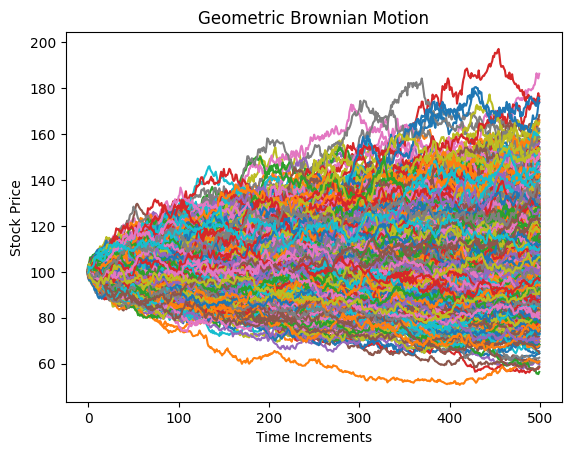

In [6]:
BlackScHolesObject = BlackScHolesClass(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
paths = BlackScHolesObject.generateBSpaths()
BlackScHolesObject.plot_BSPaths()

Final bank balance:  0.12751027630557132
 
Multiple Hedging with different GBM path: 


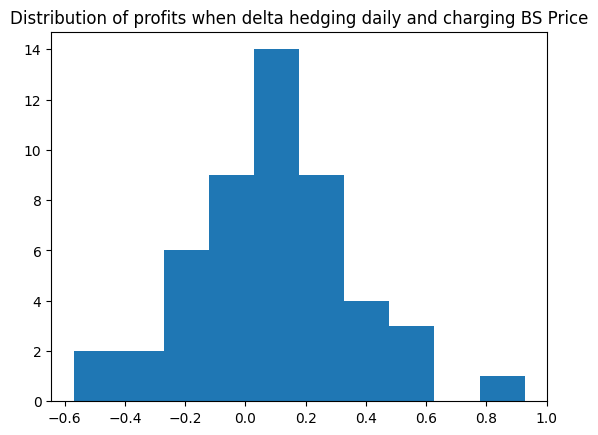

In [7]:
delta_heding = BlackScHolesObject.GetDeltaHedging()
print("Final bank balance: ", delta_heding)
print(" ")
print("Multiple Hedging with different GBM path: ")
Multplit_delta_hedging = BlackScHolesObject.MultipleDataHedging()